## Model Training
Due to dataset size, the model is trained on Kaggle.com.
Training and evaluation scripts are viewable on https://www.kaggle.com/code/worker444/twibot22-hgt/notebook (all versions of the notebook).

In [3]:
# load data
import torch 
import pandas as pd
import os

data = torch.load('data/TwiBot22_Graph_with_degreecounts3.pt')
node_ids = torch.load('data/unique_nodes.pt')
    
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# remove user ids that are not in the graph
train_df = train_df[train_df['user_id'].isin(node_ids)]
test_df = test_df[test_df['user_id'].isin(node_ids)]

train_df['index'] = train_df['user_id'].apply(lambda x: node_ids[x])
test_df['index'] = test_df['user_id'].apply(lambda x: node_ids[x])
labels = train_df[['index', 'label']].values.tolist() + test_df[['index', 'label']].values.tolist()
sorted_labels = sorted(labels, key=lambda x: x[0])

assert list([x[0] for x in sorted_labels]) == list(range(0, len(sorted_labels)))

data['user'].y = torch.tensor([x[1] for x in sorted_labels])

subgraph_train_indices = {}
for node_type in data.node_types:
    subgraph_train_indices[node_type] = torch.arange(data[node_type]['num_nodes']).long()

subgraph_train_indices['user'] = torch.tensor(train_df['index'].values).long()

train_graph = data.subgraph(
    subgraph_train_indices
)

if not os.path.exists('data/TwiBot22_Graph_with_degreecounts_with_y.pt'):
    torch.save(data, 'data/TwiBot22_Graph_with_degreecounts_with_y.pt')
    torch.save(train_graph, 'data/TwiBot22_Graph_with_degreecounts_train_with_y.pt')
    
del data

In [2]:
# Define GNN Model
from torch_geometric.nn import HGTConv, Linear
import torch 
from torch.nn import functional as F

class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, node_types, data_metadata):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data_metadata,
                           num_heads, group='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return self.lin(x_dict['user'])
    
    
    
model = HGT(hidden_channels=256, out_channels=1, num_heads=8, num_layers=2, node_types=train_graph.node_types, data_metadata=train_graph.metadata())

In [3]:
from torch_geometric.loader import HGTLoader
batch_size = 32
num_node_types = len(train_graph.node_types)
one_hop_neighbors = (20 * batch_size)//num_node_types # per relationship type
two_hop_neighbors = (20 * 8 * batch_size)//num_node_types # per relationship type
#three_hop_neighbors = (20 * 8 * 3 * batch_size)//num_node_types # per relationship type
num_neighbors = [one_hop_neighbors, two_hop_neighbors]

loader = HGTLoader(
        train_graph,
        num_samples=num_neighbors,
        batch_size=32,
        input_nodes=('user', torch.arange(0, len(train_graph['user'].y)).long()),
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2,
        shuffle=True
    )

In [ ]:
# train model 
from tqdm.auto import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()  # more numerically stable than standard BCE because of log sum exp trick https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_folder = Path(f'runs/{timestamp}')
writer = SummaryWriter(run_folder)
model.train()
model.cuda()
for epoch in range(100):
    for i,minibatch in enumerate(loader):
        minibatch = minibatch.cuda()
        optimizer.zero_grad()
        out = model(minibatch.x_dict, minibatch.edge_index_dict)
        loss = criterion(out, minibatch.y)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0 or i == len(loader) - 1:
            writer.add_scalar('Loss/train', loss.item(), (i+1)*32)
        
        if i % 1000 == 0 or i == len(loader) - 1:
            torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    }, run_folder/f'model_samplesseen{(i+1)*32}.pt')


In [ ]:
# sample evaluation code (the whole code can be found at https://www.kaggle.com/code/worker444/twibot22-hgt?scriptVersionId=162665197):
del node_ids
gc.collect()
data = data.cuda()


model.cuda()
with open('/kaggle/working/scores.csv', 'w') as csv_file:
    csv_file.write('Samplesseen,F1\n')
    for path in [
       '/kaggle/input/twibot22-hgt-models/model_samplesseen2791744.pt',
        '/kaggle/input/twibot22-hgt-models/model_samplesseen2951744.pt',
        '/kaggle/input/twibot22-hgt-models/model_samplesseen3111744.pt',
        '/kaggle/input/twibot22-hgt-models/model_samplesseen3335744.pt',
        '/kaggle/input/twibot22-hgt-models/model_samplesseen3463744.pt',
        '/kaggle/input/twibot22-hgt-models/model_samplesseen3591744.pt'
        
    ]:
        print('Loading state dict:',path)

        init(model,path)
        test_loader = HGTLoader(
            data,
            num_samples=num_neighbors,
            batch_size=32,
            input_nodes=('user', test_df['index'].values.tolist()),  # in testing the model can see the training user nodes, but only test nodes are used for testing
            num_workers=4,
            pin_memory=True,
            prefetch_factor=2,
            shuffle=True
        )

        with torch.no_grad():
            model.eval()
            y_hat = []
            y = []
            for i,minibatch in tqdm(enumerate(test_loader)):
                out = model(minibatch.x_dict, minibatch.edge_index_dict)
                yhat_b = (out>0).cpu().numpy()
                y_b = minibatch['user'].y.unsqueeze(1).float().cpu().numpy()
                print(i, f1_score(yhat_b, y_b), end='\r')
                y_hat.append(yhat_b)
                y.append(y_b)

            y_hat = np.concatenate(y_hat)
            y = np.concatenate(y)
            print('')
            f1= f1_score(y_hat, y)
            samplesseen = int(path.replace('/kaggle/input/twibot22-hgt-models/model_samplesseen','').replace('.pt',''))
            print('final',f1, 'samplesseen',samplesseen)
            print('')
            
            csv_file.write(f'{samplesseen},{f1}\n')

        del test_loader

### Experimental Results
Below, the training loss and validation F1 score are shown (Figure 1 and 2). The model is trained for 10 epochs.
One training epoch amounts to 6.8 hours, and total training time to 68 hours on a NVIDIA P100 GPU.

One training epoch corresponds to 810,000 node classifications. The model is trained with the Adam optimizer and a learning rate of 0.0002 and a minibatch size of 32. The evaluation is done on the remaining 90,000 nodes, which the model has not seen.



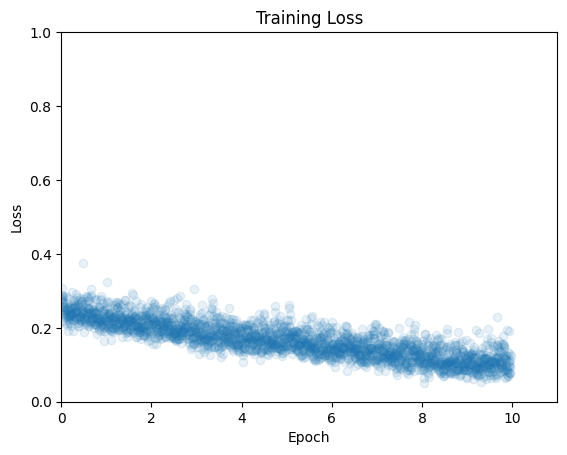

Figure 1: Training Loss. The loss decreases almost linearly.


In [54]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
        
    return runlog_data
df=tflog2pandas("training_data")

import matplotlib.pyplot as plt
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.xlim(0,11)
plt.scatter(df[df['metric']=='Loss/train']['step']/810000,df[df['metric']=='Loss/train']['value'], alpha=0.1)
plt.show()
print('Figure 1: Training Loss. The loss decreases almost linearly.')

Maximum F1:
   Samplesseen       F1  precision    recall
4      7047872  0.69603   0.615349  0.801059


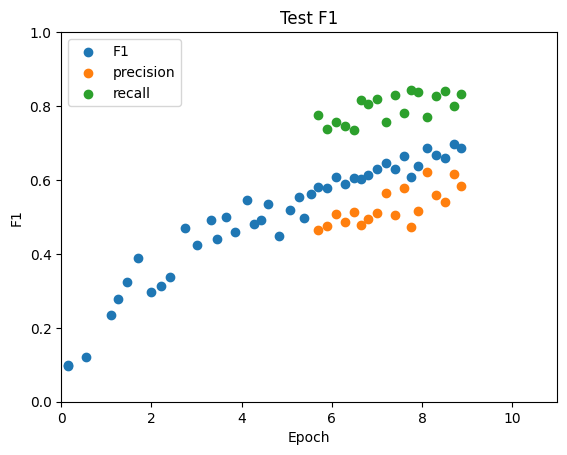

Figure 2: Test F1, precision and recall. Precision and recall are only recorded from epoch 5 onwards. 
Further epochs could still improve the model's performance. Since the scores are still increasing, it 
has not overfit to the training set yet.


In [55]:
import os 
csv_data= []
for path in os.listdir("training_data"):
    if path.endswith('.csv'):
        df = pd.read_csv("training_data/"+path)
        csv_data.append(df)

df = pd.concat(csv_data)
print('Maximum F1:')
print(df[df['F1']==df['F1'].max()])
plt.title('Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.scatter(df['Samplesseen']/810000,df['F1'], label='F1')
plt.scatter(df['Samplesseen']/810000,df['precision'],label='precision')
plt.scatter(df['Samplesseen']/810000,df['recall'],label='recall')
plt.xlim(0,11)
plt.ylim(0,1)
plt.legend();
plt.show()
print("Figure 2: Test F1, precision and recall. Precision and recall are only recorded from epoch 5 onwards. \nFurther epochs could still improve the model's performance. Since the scores are still increasing, it \nhas not overfit to the training set yet.")

### Discussion
The model achieves an F1 score of more than 69%, outperforming all models from the original Twibot-22 paper [2] (The best model achieves an F1 score of 58%).
Interestingly, their implementation of the Heterogeneous Graph Transformer architecture only achieves an F1 of 39%. Since a naive logistic regression achieves an F1 score of 43% (as evaluated earlier), the performance of 69% is plausible.

Opposed to the original implementation in Twibot-22, we only utilize the graph information (relationship information) as initial node features. The original implementation also leverages text information from user descriptions and tweets as well as numerical and categorical user property information.

Unfortunately, the original paper lacks a description of data splitting and the training approach or schedule. The performance deviation could be caused by insufficient training in the original paper's case.
Inspecting Figure 2, the F1 score only increases after the model has trained by making at least 810,000 classifications (one epoch). Perhaps the authors limited the training, since the main subject of the Twibot-22 paper is the dataset itself, and the authors had to compare many different models. They provide the testing performance in comparison to earlier datasets in the field, such that their results are still interpretable.
